In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

! pip install git+https://github.com/openai/CLIP.git
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import clip
import torch

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Import CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 131MiB/s]


In [ ]:
tokenizer = clip.tokenize
token_embedding = clip_model.token_embedding


In [ ]:
# Hard prompts made easy
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.23.1 sentence-transformers==2.2.2 ftfy==6.1.1 mediapy==1.1.2 diffusers==0.11.1
    !git clone https://github.com/YuxinWenRick/hard-prompts-made-easy
    %cd hard-prompts-made-easy

!pip install accelerate

import torch
import open_clip
import mediapy as media
from optim_utils import *
import argparse

args = argparse.Namespace()
args.__dict__.update(read_json("sample_config.json"))

# Load Clip Model of Hard prompts made easy
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, clip_preprocess = open_clip.create_model_and_transforms(args.clip_model, pretrained=args.clip_pretrain, device=device)

tokenizer = open_clip.tokenizer._tokenizer
token_embedding = model.token_embedding
preprocess = clip_preprocess

from diffusers import DPMSolverMultistepScheduler, StableDiffusionPipeline

model_id = "stabilityai/stable-diffusion-2-1-base"
scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
    revision="fp16",
    )
pipe = pipe.to(device)

image_length = 512

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]


# CUB



In [ ]:
def compute_loss(a, b, c):
    a = 1 - torch.mean(a)
    b = 1 - torch.mean(b)
    c = 1 - torch.mean(c)
  
    loss = (a + b - c)

    return loss
     

In [ ]:
def compute_loss_4(a, b, c, d):
    a = 1 - torch.mean(a)
    b = 1 - torch.mean(b)
    c = 1 - torch.mean(c)
    d = 1 - torch.mean(d)
    loss = (a + b - c - d)

    return loss
     

In [ ]:
def compute_simalirities_images(text, images):
    cos_sim_1 = 0
    for image in images:
      cos_sim_1 += torch.nn.functional.cosine_similarity(text.unsqueeze(1), image.unsqueeze(0), dim=-1)

    return cos_sim_1/len(images)

In [ ]:
import os

text_1 = "a bird with a on a branch"
image_1_original = []
image_2_original = []
count = 0
for filename in os.listdir("/content/drive/MyDrive/CUB_200_2011/CUB_200_2011/images/165.Chestnut_sided_Warbler/"):
  if count == 10:
    break
  print(filename)
  image_1_original.append(Image.open("/content/drive/MyDrive/CUB_200_2011/CUB_200_2011/images/165.Chestnut_sided_Warbler/{}".format(filename)))
  count+=1


count = 0
text_2 = "a bird with a small neck on a branch"
for filename in os.listdir("/content/drive/MyDrive/Birds/CUB_200_2011/images/061.Heermann_Gull/"):
  if count == 10:
    break
  image_2_original.append(Image.open("/content/drive/MyDrive/Birds/CUB_200_2011/images/061.Heermann_Gull/{}".format(filename)))
  count+=1


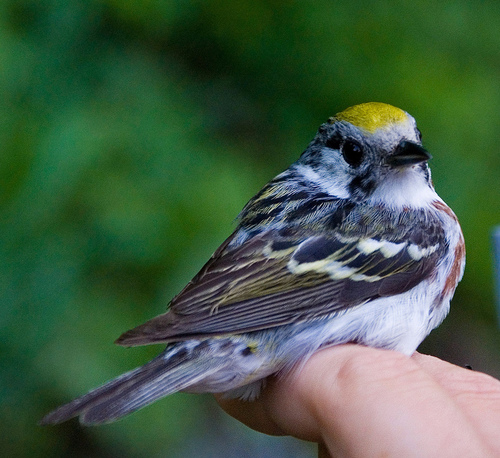

In [ ]:
Image.open("/content/drive/MyDrive/CUB_200_2011/CUB_200_2011/images/165.Chestnut_sided_Warbler/Chestnut_Sided_Warbler_0098_164352.jpg")

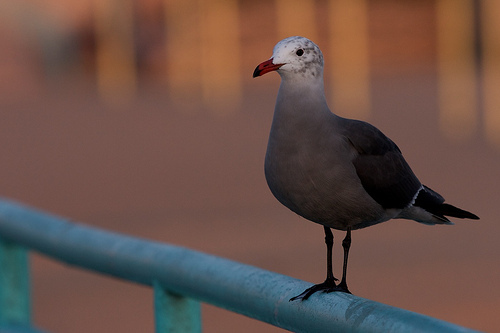

In [ ]:
Image.open("/content/drive/MyDrive/Birds/CUB_200_2011/images/061.Heermann_Gull/Heermann_Gull_0004_45936.jpg")

In [ ]:
# Preprocess text
text_1 = tokenizer([text_1],truncate=True).to(device)

text_2 = tokenizer([text_2],truncate=True).to(device)

In [ ]:
# Preprocess images
image_1 = []
image_2 = []
for image in image_1_original:
  image_1.append(preprocess(image).unsqueeze(0).to(device))

for image in image_2_original:
  image_2.append(preprocess(image).unsqueeze(0).to(device))

In [ ]:
import torchvision.transforms as T
from PIL import Image

transform = T.ToPILImage()

# With 3 elem loss




In [ ]:
torch.set_grad_enabled(True)

# Encode text 1
text_1_embed = clip_model.encode_text(text_1).detach()
text_1_embed.requires_grad_()

# Encode image 1
image_1_embed = []
for image in image_1: 
  image_embed = clip_model.encode_image(image).detach()
  image_embed.requires_grad_()
  image_1_embed.append(image_embed)

# Encode text 2
text_2_embed = clip_model.encode_text(text_2).detach()
text_2_embed.requires_grad_()

# Encode question 2
image_2_embed = []
for image in image_2: 
  image_embed = clip_model.encode_image(image).detach()
  image_embed.requires_grad_()
  image_2_embed.append(image_embed)

In [ ]:
# sanity test new image
sanity_image = Image.open("/content/drive/MyDrive/Birds/CUB_200_2011/images/165.Chestnut_sided_Warbler/Chestnut_Sided_Warbler_0086_164024.jpg")
sanity_image_preprocess = preprocess(sanity_image).unsqueeze(0).to(device)
sanity_image_embed = clip_model.encode_image(sanity_image_preprocess).detach()

true_class =  torch.nn.functional.cosine_similarity(text_1_embed.unsqueeze(1), sanity_image_embed.unsqueeze(0), dim=-1)
false_class =  torch.nn.functional.cosine_similarity(text_2_embed.unsqueeze(1), sanity_image_embed.unsqueeze(0), dim=-1)

print("Similarity for true class is: {}".format(true_class.item()))
print("Similarity for false class is: {}".format(false_class.item()))

Similarity for true class is: 0.28759765625
Similarity for false class is: 0.315185546875


In [ ]:
# Initialize optimizer
optimizer = torch.optim.SGD([text_1_embed, text_2_embed], lr=0.05)

sim_1 = []
sim_2 = []
sim_3 = []
losses = []

# Iterations
num_epochs = 1000

for epoch in range(num_epochs):
  optimizer.zero_grad()

  # Compute similarities
  cos_sim_1 = compute_simalirities_images(text_1_embed, image_1_embed)
  cos_sim_2 = compute_simalirities_images(text_2_embed, image_2_embed)
  cos_sim_3 = torch.nn.functional.cosine_similarity(text_1_embed.unsqueeze(1), text_2_embed.unsqueeze(0), dim=-1)
  cos_sim_4 = compute_simalirities_images(text_1_embed, image_2_embed)
  cos_sim_5 = compute_simalirities_images(text_2_embed, image_1_embed)

  # Compute loss
  loss = compute_loss(cos_sim_1, cos_sim_2, cos_sim_3)
  # Backpropagation
  loss.backward()
  if epoch % 100 == 0: 
    print("The loss is for epoch {}: {}".format(epoch, loss))
    print("The similarity between text 1 and image 1 is: {}".format(cos_sim_1.item()))
    print("The similarity between text 2 and image 2 is: {}".format(cos_sim_2.item()))
    print("The similarity between text 1 and 2 is: {}".format(cos_sim_3.item()))
    print("The similarity between text 1 and image 2 is: {}".format(cos_sim_4.item()))
    print("The similarity between text 2 and image 1 is: {}".format(cos_sim_5.item()))


  sim_1.append(cos_sim_1[0][0].cpu().detach().numpy())
  sim_2.append(cos_sim_2[0][0].cpu().detach().numpy())
  sim_3.append(cos_sim_3[0][0].cpu().detach().numpy())
  losses.append(loss.cpu().detach().numpy())

  # Optimizer step
  optimizer.step()

Text(0.5, 1.0, 'Similarity text 1/text 2')

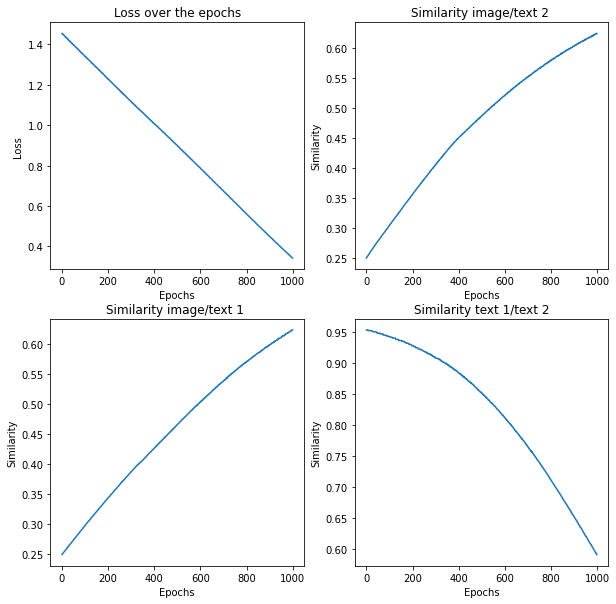

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (10,10))
epochs = np.arange(num_epochs)

axes[0][0].plot(epochs, losses)
axes[0][0].set_ylabel("Loss")
axes[0][0].set_xlabel("Epochs")
axes[0][0].set_title("Loss over the epochs")

axes[1][0].plot(epochs, sim_1)
axes[1][0].set_ylabel("Similarity")
axes[1][0].set_xlabel("Epochs")
axes[1][0].set_title("Similarity image/text 1 ")

axes[0][1].plot(epochs, sim_2)
axes[0][1].set_ylabel("Similarity")
axes[0][1].set_xlabel("Epochs")
axes[0][1].set_title("Similarity image/text 2 ")

axes[1][1].plot(epochs, sim_3)
axes[1][1].set_ylabel("Similarity")
axes[1][1].set_xlabel("Epochs")
axes[1][1].set_title("Similarity text 1/text 2")

In [ ]:
# sanity test new image
sanity_image = Image.open("/content/drive/MyDrive/Birds/CUB_200_2011/images/165.Chestnut_sided_Warbler/Chestnut_Sided_Warbler_0086_164024.jpg")
sanity_image_preprocess = preprocess(sanity_image).unsqueeze(0).to(device)
sanity_image_embed = clip_model.encode_image(sanity_image_preprocess).detach()

true_class =  torch.nn.functional.cosine_similarity(text_1_embed.unsqueeze(1), sanity_image_embed.unsqueeze(0), dim=-1)
false_class =  torch.nn.functional.cosine_similarity(text_2_embed.unsqueeze(1), sanity_image_embed.unsqueeze(0), dim=-1)

print("Similarity for true class is: {}".format(true_class.item()))
print("Similarity for false class is: {}".format(false_class.item()))

Similarity for true class is: 0.65478515625
Similarity for false class is: 0.487548828125


In [ ]:
# sanity test new image
sanity_image = Image.open("/content/drive/MyDrive/Birds/CUB_200_2011/images/061.Heermann_Gull/Heermann_Gull_0131_45548.jpg")
sanity_image_preprocess = preprocess(sanity_image).unsqueeze(0).to(device)
sanity_image_embed = clip_model.encode_image(sanity_image_preprocess).detach()

true_class =  torch.nn.functional.cosine_similarity(text_1_embed.unsqueeze(1), sanity_image_embed.unsqueeze(0), dim=-1)
false_class =  torch.nn.functional.cosine_similarity(text_2_embed.unsqueeze(1), sanity_image_embed.unsqueeze(0), dim=-1)

print("Similarity for true class is: {}".format(true_class.item()))
print("Similarity for false class is: {}".format(false_class.item()))

Similarity for true class is: 0.477783203125
Similarity for false class is: 0.623046875


In [ ]:
best_prompt_image_1 =  optimize_prompt(model, preprocess, args, device, target_images=[(image_1_original)])

best_prompt_image_2 =  optimize_prompt(model, preprocess, args, device, target_images=[(image_2_original)])

best_prompt_final_embedding_image_1 =  optimize_prompt(model, preprocess, args, device, target_images=[transform(image_1_embed)])

best_prompt_final_embedding_image_2 =  optimize_prompt(model, preprocess, args, device, target_images=[transform(image_2_embed)])

In [ ]:
print("Best prompt for image 1 is: {}".format(best_prompt_image_1))
print("Best prompt for image 2 is: {}".format(best_prompt_image_2))
print("Best prompt for last embedding of image 1 is: {}".format(best_prompt_final_embedding_image_1))
print("Best prompt for last embedding of image 2 is: {}".format(best_prompt_final_embedding_image_2))

Best prompt for image 1 is: shelbyisdspecies wildatlanticway mississauga planrainforest biodiversity stewards distinctive bardsubaru bacher birds mike nwt 
Best prompt for image 2 is: darylmariner song putnam ored nafta bird incentives declines yeats tsn ultimatefanthreatened disease eleague typically 
Best prompt for last embedding of image 1 is: online webdev kiev registry password [ . grataccident ((( urstruly�victims burglcyclones cracks 
Best prompt for last embedding of image 2 is: kickstarter declared galvani�▂▂▂�userkiev installment declared existed �▂�, া precau)" mondays 


# With 4 elem loss




In [ ]:
torch.set_grad_enabled(True)

# Encode text 1
text_1_embed = model.encode_text(text_1).detach()
text_1_embed.requires_grad_()
# Encode image 1
image_1_embed = model.encode_image(image_1).detach()
image_1_embed.requires_grad_()
# Encode text 2
text_2_embed = model.encode_text(text_2).detach()
text_2_embed.requires_grad_()
# Encode question 2
image_2_embed = model.encode_image(image_2).detach()
image_2_embed.requires_grad_()

# Initialize optimizer
optimizer = torch.optim.SGD([text_1_embed, image_1_embed, text_2_embed, image_2_embed], lr=0.5)

sim_1 = []
sim_2 = []
sim_3 = []
sim_4 = []
losses = []

# Iterations
num_epochs = 100

for epoch in range(num_epochs):
  optimizer.zero_grad()

  # Compute similarities
  cos_sim_1 = torch.nn.functional.cosine_similarity(text_1_embed.unsqueeze(1), image_1_embed.unsqueeze(0), dim=-1)
  cos_sim_2 = torch.nn.functional.cosine_similarity(text_2_embed.unsqueeze(1), image_2_embed.unsqueeze(0), dim=-1)
  cos_sim_3 = torch.nn.functional.cosine_similarity(text_1_embed.unsqueeze(1), text_2_embed.unsqueeze(0), dim=-1)
  verification_sim = torch.nn.functional.cosine_similarity(image_1_embed.unsqueeze(1), image_2_embed.unsqueeze(0), dim=-1)

  # Compute loss
  loss = compute_loss_4(cos_sim_1, cos_sim_2, cos_sim_3, verification_sim)
  # Backpropagation
  loss.backward()
  if epoch % 20 == 0: 
    print("The loss is for epoch {}: {}".format(epoch, loss))
    print("The similarity between text 1 and image 1 is: {}".format(cos_sim_1.item()))
    print("The similarity between text 2 and image 2 is: {}".format(cos_sim_2.item()))
    print("The similarity between text 1 and 2 is: {}".format(cos_sim_3.item()))
    print("The similarity between image 1 and 2 is: {}".format(verification_sim.item()))


  sim_1.append(cos_sim_1[0][0].cpu().detach().numpy())
  sim_2.append(cos_sim_2[0][0].cpu().detach().numpy())
  sim_3.append(cos_sim_3[0][0].cpu().detach().numpy())
  sim_4.append(verification_sim[0][0].cpu().detach().numpy())
  losses.append(loss.cpu().detach().numpy())

  # Optimizer step
  optimizer.step()

Text(0.5, 1.0, 'Similarity image 1/image 2')

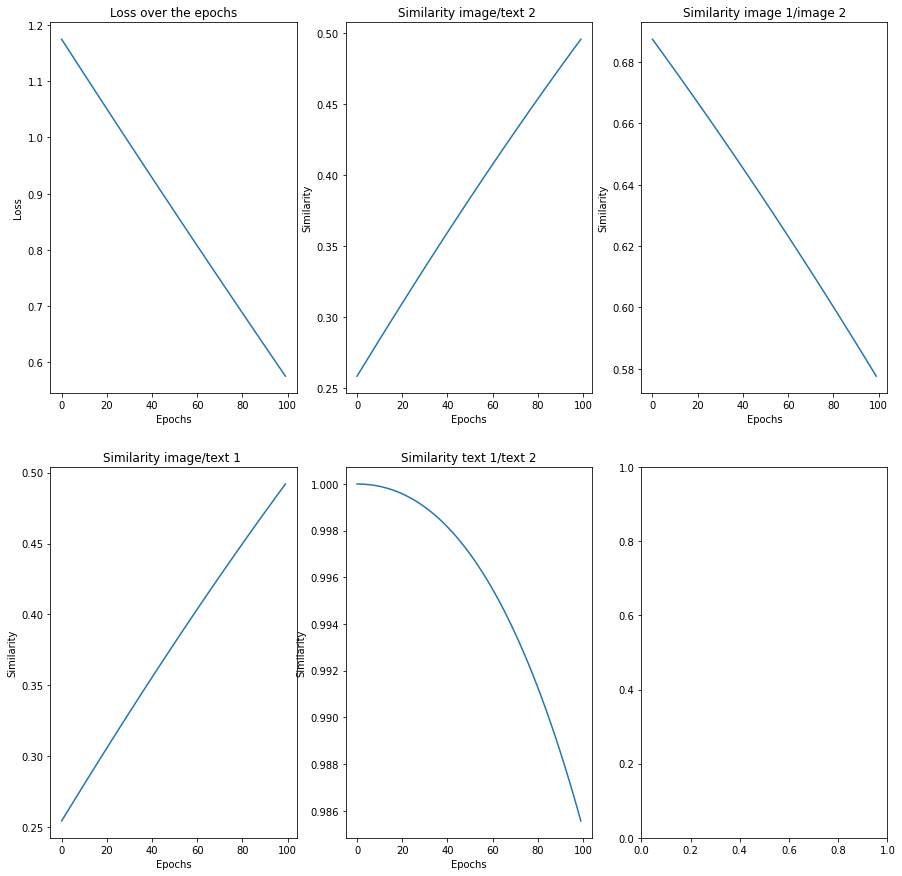

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (15,15))
epochs = np.arange(num_epochs)

axes[0][0].plot(epochs, losses)
axes[0][0].set_ylabel("Loss")
axes[0][0].set_xlabel("Epochs")
axes[0][0].set_title("Loss over the epochs")

axes[1][0].plot(epochs, sim_1)
axes[1][0].set_ylabel("Similarity")
axes[1][0].set_xlabel("Epochs")
axes[1][0].set_title("Similarity image/text 1 ")

axes[0][1].plot(epochs, sim_2)
axes[0][1].set_ylabel("Similarity")
axes[0][1].set_xlabel("Epochs")
axes[0][1].set_title("Similarity image/text 2 ")

axes[1][1].plot(epochs, sim_3)
axes[1][1].set_ylabel("Similarity")
axes[1][1].set_xlabel("Epochs")
axes[1][1].set_title("Similarity text 1/text 2")

axes[0][2].plot(epochs, sim_4)
axes[0][2].set_ylabel("Similarity")
axes[0][2].set_xlabel("Epochs")
axes[0][2].set_title("Similarity image 1/image 2")

# Saleforce

In [ ]:
!pip install salesforce-lavis

In [ ]:
import torch
from lavis.models import load_model_and_preprocess
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# loads BLIP caption base model, with finetuned checkpoints on MSCOCO captioning dataset.
# this also loads the associated image processors
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device)

In [ ]:
# preprocess the image
# vis_processors stores image transforms for "train" and "eval" (validation / testing / inference)
raw_image = Image.open("/content/drive/MyDrive/CUB_200_2011/CUB_200_2011/images/165.Chestnut_sided_Warbler/Chestnut_Sided_Warbler_0096_163672.jpg").convert("RGB")
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
# generate caption
model.generate({"image": image})